In [1]:
import os
import copy
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import seaborn as sns
import geopandas as gpd
from intercluster import *
from intercluster.decision_trees import *
from intercluster.decision_sets import *
from intercluster.pruning import *
from intercluster.mining import *
from intercluster.experiments import *

# Helps with KMeans memory leak issues.
os.environ["OMP_NUM_THREADS"] = "1"

%load_ext autoreload
%autoreload 2

In [2]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 342
np.random.seed(seed)

In [3]:
# This assumes tex is installed in your system, 
# if not, you may simply remove most of this, aside from font.size 
# (although this will break certain plotting functions)
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 24
})

palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

color_dict = {
    -2: 'grey',
    -1: 'white',
    0: cmap(0),
    1: cmap(1),
    2: cmap(3),
    3: cmap(4),
    4: cmap(5),
    5: cmap(6),
    6: cmap(2),
    7: cmap(7)
}

subset_colors = [cmap(0), cmap(1), cmap(3), cmap(4), cmap(5), cmap(6)]
cmap_subset = ListedColormap(subset_colors)

uncovered_color = (1,1,1)
overlap_color = (0.45, 0.5, 0.5)

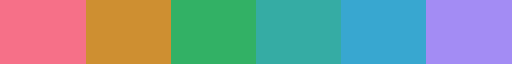

In [4]:
cmap_subset

# A Case Study with Climate Data

Throughout the following notebook we showcase a study of interpretable clustering 
applied to a climate dataset attributed to NOAA. While bein an interesting 
study on its own, this should also give a better idea for how pieces of the repository are 
put together to create working models. 

NOAA National Centers for Environmental information, Climate at a Glance: Regional Time Series, 
published March 2025, retrieved on March 13, 2025 from 
https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/regional/time-series

### Load Data

In [5]:
# We first load and preprocess the data, the first part which is in the form of 
# geographical shape files (used for plotting maps).
filepath = '../data/climate'
shape_file_path = os.path.join(filepath, 'climate_divisions/climate_divisions.shp')
dtype_dict = {'CLIMDIV': 'str'}
gdf = gpd.read_file(shape_file_path, dtype = dtype_dict)
gdf['CLIMDIV'] = gdf['CLIMDIV'].apply(lambda x: f'{int(x):04d}')

# Next the temperature and precipitation data:
data_file_path = os.path.join(filepath, 'climate.csv')
climate_data = pd.read_csv(data_file_path, dtype={'ID': str, 'Year': str})
climate_data.set_index(['ID', 'Year'], inplace=True)

# This is grouped into historical and recent time periods, for which we take averages.
historical_years = [str(i) for i in range(1900,2000)]
recent_years = [str(i) for i in range(2013,2024)]
historical = climate_data.loc[pd.IndexSlice[:, historical_years], :]
recent = climate_data.loc[pd.IndexSlice[:, recent_years], :]
historical_avg = historical.groupby(level='ID').mean()
recent_avg = recent.groupby(level='ID').mean()

# The percent change in values is then taken to be the relative difference between averages.
climate_change = (recent_avg - historical_avg)/historical_avg
climate_change = climate_change.loc[gdf.CLIMDIV,:]
    
# Finally, we normalize the data using standard scaling.
data = climate_change.to_numpy()
feature_labels = list(climate_change.columns)
location_ids = list(climate_change.index)

scaler = StandardScaler()
data = scaler.fit_transform(data)

/Users/quinn/research/intercluster/repo/.venv/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option DTYPE
  return ogr_read(


In [6]:
# The result is a dataframe in which indices represent 344 climate division locations 
# and columns represent 24 feature variables for temperature and percipitation in each of 12 months. 
pd.DataFrame(data, columns = feature_labels, index = location_ids)

,pcpn_jan,pcpn_feb,pcpn_mar,pcpn_apr,pcpn_may,pcpn_june,pcpn_july,pcpn_aug,pcpn_sept,pcpn_oct,...,temp_mar,temp_apr,temp_may,temp_june,temp_july,temp_aug,temp_sept,temp_oct,temp_nov,temp_dec
2905,-0.198615,-1.364177,-1.696197,-2.361933,-2.150596,0.282812,0.054435,-1.400706,0.430836,-1.435015,...,1.162424,1.427699,0.615274,1.283736,1.162756,0.517064,0.227658,0.340202,1.058682,-0.491697
2906,-1.154730,-1.740913,-1.079289,-1.901910,-2.326618,0.124945,-0.226465,-1.003840,0.015835,-0.041192,...,1.563485,1.333036,0.489056,1.514339,1.503711,0.793433,0.758538,0.420567,0.959211,-0.353056
1001,-0.716290,-0.557973,1.256743,0.105012,-0.610140,-0.278129,-2.498229,-1.348456,-0.264055,-0.531527,...,0.278511,-0.123189,2.591228,1.248566,2.023327,2.439460,0.151504,0.011316,0.593739,-0.993994
1002,-1.309264,0.607880,0.600404,0.097091,-1.108310,-0.653687,-2.829937,-1.711986,-0.852142,-0.853133,...,-0.197367,0.030647,1.660127,0.820536,1.454558,1.580793,-0.257755,-0.405805,-0.208115,-1.315722
1004,-1.574654,-0.085140,0.458818,-0.201139,-1.172796,-0.737123,-2.216644,-0.902910,0.165364,-0.843537,...,1.456550,0.237285,1.645673,1.389169,1.703902,1.524630,0.142918,-0.076656,0.895974,-0.852607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907,0.274641,-2.162483,-1.094716,-2.138319,-2.391977,-0.673876,-0.642040,-0.864702,0.323026,0.820739,...,0.859811,0.733312,0.909512,1.255290,1.522544,1.105663,0.657067,0.308382,0.554466,-0.373356
2901,1.165863,-0.909875,-0.894640,-2.752126,-0.684243,-1.335821,-0.196442,-1.773970,-0.047176,-2.446128,...,1.097188,1.082323,0.072923,1.654971,1.126414,0.597996,0.694038,-0.175563,1.084698,-0.599233
2902,0.751138,-0.880315,-0.555642,-2.355618,-1.266145,-0.648846,0.360114,-1.599392,0.552542,-1.082896,...,1.445663,0.890328,-0.101180,1.107287,0.736940,0.077424,0.754874,0.009638,1.348169,-0.375041
2908,-0.013678,-1.687235,-0.841409,-2.414647,-3.194155,0.440300,-0.007373,-0.582962,0.613599,-0.737068,...,0.676059,1.439690,0.389527,1.076686,0.813141,0.632151,-0.211139,0.497051,0.977901,-0.685823


### KMeans

As a reference, we compute a standard clustering. 

In [7]:
# To select a number of clusters, we'll simply analyze the change in cost as k is increased.
samples = 100
num_clusters_trials = np.array([2,3,4,5,6,7,8,9,10])
num_clusters_costs = np.zeros((len(num_clusters_trials), samples))

for i, nclusters in enumerate(num_clusters_trials):
    for j in range(samples):
        kmeans = KMeans(n_clusters=nclusters, n_init="auto", random_state = None).fit(data)
        kmeans_labels = labels_format(kmeans.labels_)
        kmeans_assignment = labels_to_assignment(kmeans_labels, n_labels = nclusters)
        cost = kmeans_cost(data, kmeans.cluster_centers_, kmeans_assignment)
        num_clusters_costs[i,j] = cost

Text(0.5, 0, 'Number of clusters')

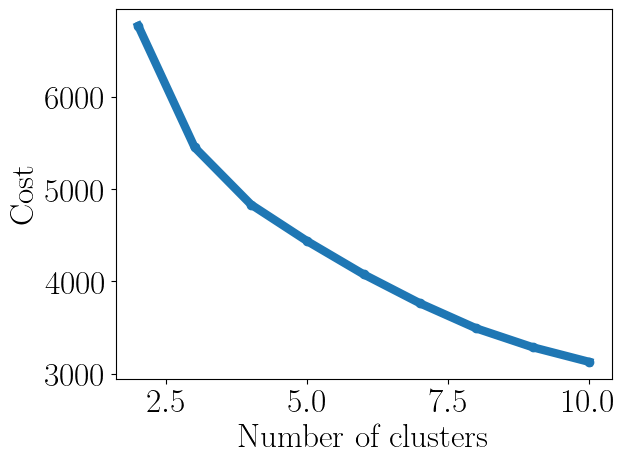

In [9]:
plt.plot(num_clusters_trials, np.mean(num_clusters_costs, axis = 1), marker = 'o', linewidth = 6)
plt.ylabel('Cost')
plt.xlabel('Number of clusters')

In [8]:
# We'll say that a good clustering comes at around 6 clusters,
# and use this throughout our experiments

np.random.seed(342)
k = 6
kmeans = KMeans(n_clusters=k, n_init="auto", random_state = None).fit(data)
kmeans_labels = labels_format(kmeans.labels_)
kmeans_assignment = labels_to_assignment(kmeans_labels, n_labels = k)

# Note that to compute a normalized clustering cost (to account for coverage and overlap)
# set the average and normalize parameters to `True`
cost = kmeans_cost(
    data,
    kmeans.cluster_centers_,
    kmeans_assignment,
    average = True,
    normalize = True
)
print("Cost: " + str(cost))

Cost: 11.660924946384164


([], [])

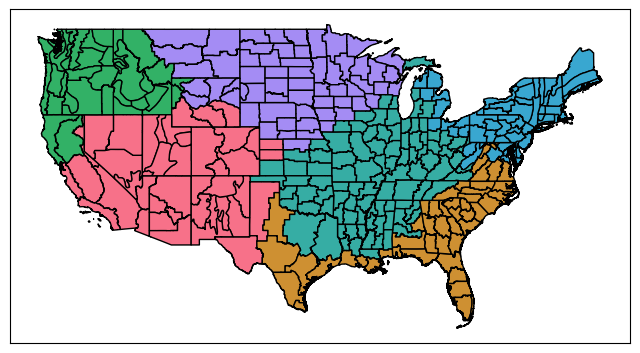

In [9]:
# We then visualize the clustering by coloring locations on the map by their 
# corresponding cluster.

color_label_array = np.empty(len(gdf))
color_label_array[:] = np.nan
for i,id in enumerate(location_ids):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        color_label_array[idx[0]] = list(kmeans_labels[i])[0]

gdf['color'] = color_label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='color', cmap=cmap_subset, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

plt.xticks([])
plt.yticks([])
#plt.savefig('../figures/climate/kmeans_map.png', bbox_inches = 'tight', dpi = 300)

(0.0, 1.0, 0.0, 1.0)

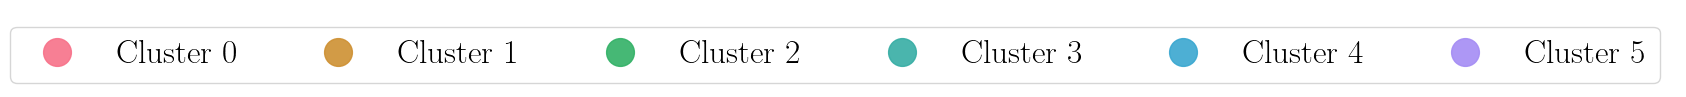

In [10]:
fig, ax = plt.subplots(figsize = (6,1))
legend_elements = [
    mlines.Line2D([], [], marker = 'o', markersize=20, color=cmap_subset(i), lw=0, label=f'Cluster {i}', alpha=0.9)
    for i in range(k)
]
ax.legend(handles=legend_elements, ncol=6)
ax.axis('off')
#plt.savefig('../figures/climate/legend.png', bbox_inches = 'tight', dpi = 300)

### DBSCAN

In [35]:
# Choose parameters by evaluating silhouette scores with respect to density distances
epsilon_search = np.linspace(np.min(density_distances[np.nonzero(density_distances)]), np.max(density_distances), 100)
n_core_search = np.arange(1,100,2)

grid_max = None
grid_max_val = -np.inf
for n_core in n_core_search:
    density_distances = density_distance(data, n_core = n_core)
    for eps in epsilon_search:
        dbscan = DBSCAN(eps=eps, min_samples=n_core)
        dbscan.fit(data)
        dbscan_labels = labels_format(dbscan.labels_, ignore = {-1})
        n_unique = len(unique_labels(dbscan_labels))
        if n_unique > 1:
            dbscan_assignment = labels_to_assignment(dbscan_labels, n_labels = n_unique)
            sil = silhouette_score(density_distances, dbscan_assignment)

            if sil > grid_max_val:
                grid_max = (eps, n_core)
                grid_max_val = sil

In [38]:
grid_max

(4.297111331941485, 3)

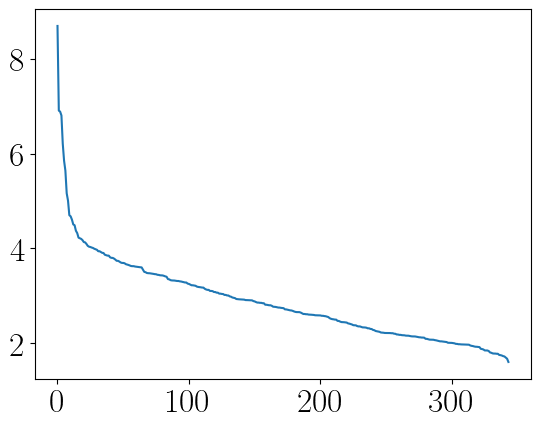

In [84]:
from sklearn.neighbors import NearestNeighbors
n_core = 6
nbrs = NearestNeighbors(n_neighbors=n_core + 1).fit(data)
distances, indices = nbrs.kneighbors(data)
distance_desc = sorted(distances[:, n_core], reverse=True)
plt.plot(distance_desc)

In [116]:
dbscan = DBSCAN(eps=1.9, min_samples=4)
dbscan.fit(data)
dbscan_labels = labels_format(dbscan.labels_)

([], [])

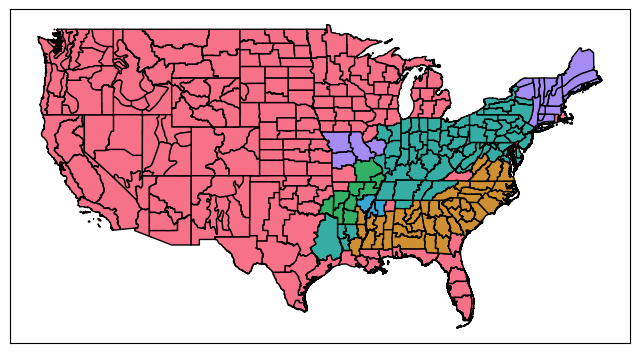

In [117]:
color_label_array = np.empty(len(gdf))
color_label_array[:] = np.nan
for i,id in enumerate(location_ids):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        color_label_array[idx[0]] = list(dbscan_labels[i])[0]

gdf['color'] = color_label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='color', cmap=cmap_subset, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

plt.xticks([])
plt.yticks([])

### IMM
Next, we show an iterative mistake minimization decision tree clustering of the dataset. 

In [11]:
exkmc_tree = ExkmcTree(
    k = k,
    kmeans = kmeans,
    max_leaf_nodes = k,
    imm = True
)

exkmc_tree.fit(data)

exkmc_labels = exkmc_tree.predict(data, leaf_labels = False)
exkmc_assignment = labels_to_assignment(exkmc_labels, n_labels = k)
exkmc_label_array = flatten_labels(exkmc_labels)
exkmc_rules, exkmc_rule_labels = get_decision_paths_with_labels(
    exkmc_tree.root,
    unique_labels(exkmc_labels)
)
imm_depth = exkmc_tree.depth

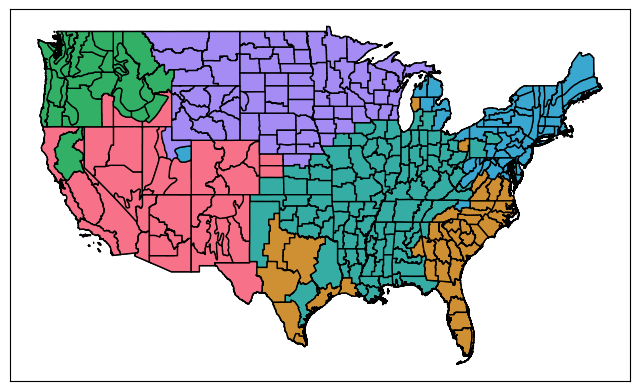

In [12]:
color_label_array = np.empty(len(gdf))
color_label_array[:] = np.nan
for i,id in enumerate(np.array(location_ids)):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        color_label_array[idx[0]] = exkmc_label_array[i]

gdf['color'] = color_label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='color', cmap=cmap_subset, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

uni_labels = gdf['color'].unique()

for l in uni_labels:
    gdf_subset = gdf[gdf['color'] == l]
    gdf_subset.plot(
        column='color',
        cmap=ListedColormap([color_dict[l]]),
        ax = ax, legend=False,
        edgecolor = 'black',
        alpha = 1
    )
 
plt.xticks([])
plt.yticks([]) 
plt.savefig('../figures/climate/imm_map.png', bbox_inches = 'tight', dpi = 300)

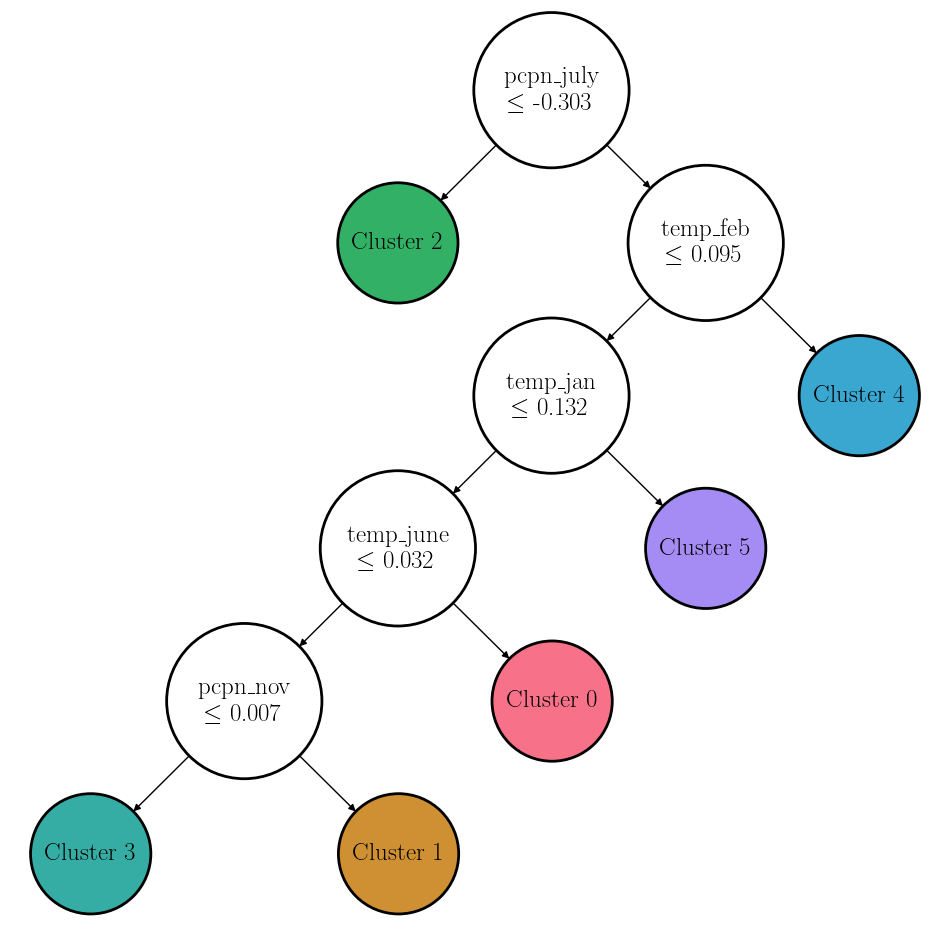

In [19]:
#fname = '../figures/climate/imm_tree.png'
fname = None

# NOTE: To draw an tree with readable data, we need to give it labels to use in place of 
# features, and we'll also need to 'unscale' the data, since it was previously normalized. 
# The following function will do these things for you if the appropriate parameters are passed.
draw_tree(
    root = exkmc_tree.root,
    feature_labels = feature_labels,
    data_scaler = scaler,
    cmap = cmap_subset,
    display_node_info = False,
    output_file = fname
)

In [20]:
# From this we may compute a few interpretability measurements:
print("Max rule length: " + str(exkmc_tree.depth))
print("Weighted average rule length: " + str(exkmc_tree.get_weighted_average_depth(data)))

Max rule length: 5
Weighted average rule length: 3.645348837209302


### Explanation Tree

Next, we show an implementation for the what we call the Explanation Tree algorithm, 
designed by Bandyapadhyay et al. in their work "How to find a good explanation for clustering?"
The algorithm works by removing outliers during the training process, aiming to find a minimal 
number of points to remove so that the resulting tree exactly replicates KMeans on everything 
that remains.

In [ ]:
exp_tree = ExplanationTree(num_clusters = k)
exp_tree.fit(data, kmeans_labels)
exp_labels = exp_tree.predict(data, remove_outliers = True)

# After fitting, we can observe its outliers attribute to see what was removed.
outliers = list(exp_tree.outliers)
non_outliers = [i for i in range(len(data)) if i not in exp_tree.outliers]
exp_label_array = flatten_labels([exp_labels[l] for l in non_outliers])

([], [])

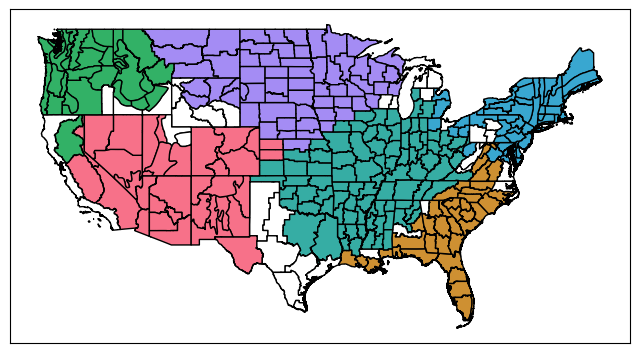

In [27]:
# Removed outliers are left uncolored:
uncover_colors = subset_colors
if len([l for l in exp_labels if len(l) == 0]) > 0:
    uncover_colors = [uncovered_color] + uncover_colors

cmap_subset_uncover = ListedColormap(uncover_colors)

color_label_array = np.empty(len(gdf))
color_label_array[:] = np.nan
for i,id in enumerate(location_ids):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        l = list(exp_labels[i])
        if len(l) == 1:
            color_label_array[idx[0]] = l[0]
        else:
            color_label_array[idx[0]] = -1

gdf['color'] = color_label_array
fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='color', cmap=cmap_subset_uncover, ax = ax, legend=False, edgecolor = 'black', alpha = 1)
 
plt.xticks([])
plt.yticks([]) 
#plt.savefig('../figures/climate/.png', bbox_inches = 'tight', dpi = 300)

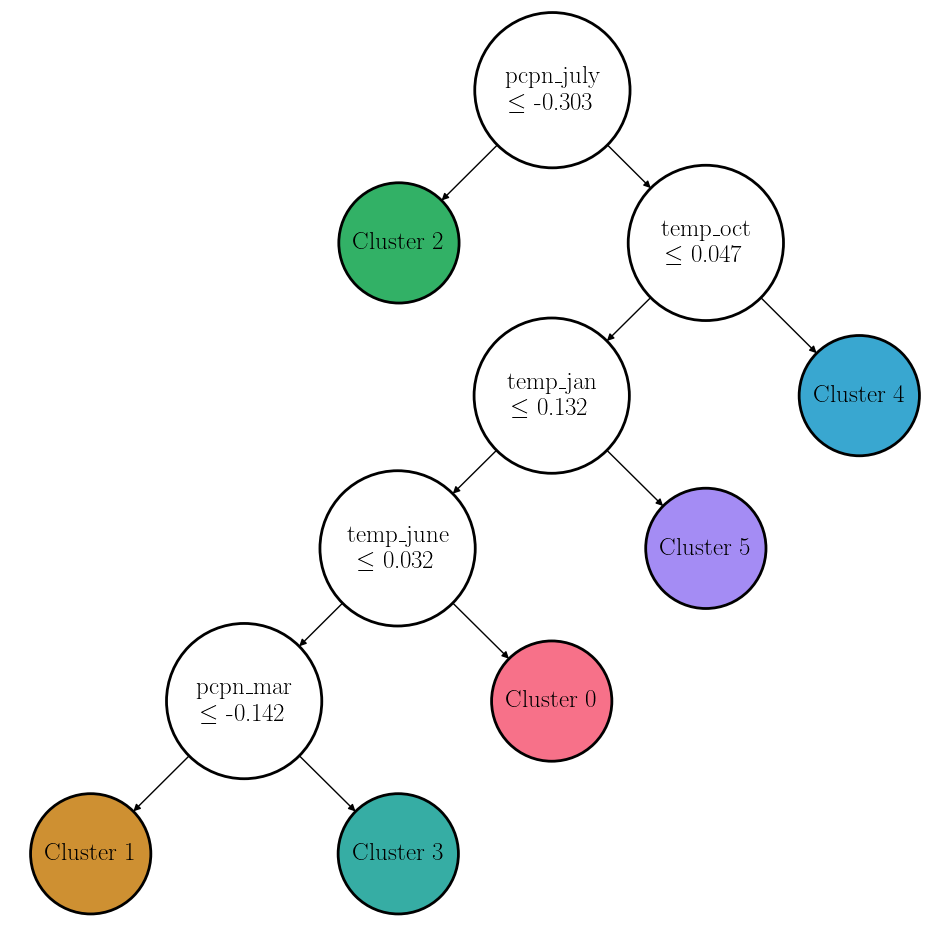

In [26]:
draw_tree(
    root = exp_tree.root,
    feature_labels = feature_labels,
    data_scaler = scaler,
    cmap = cmap_subset,
    display_node_info = False,
    output_file = None
)

In [28]:
# From this we may compute a few interpretability measurements:
print("Max rule length: " + str(exp_tree.depth))
print("Weighted average rule length: " + str(exp_tree.get_weighted_average_depth(data)))

Max rule length: 5
Weighted average rule length: 3.6143790849673203


## Decision Sets
Next, we show how to create a basic decision forest, trained with a random collection 
of one-versus-all sklearn decision trees. 

In [15]:
np.random.seed(342)

In [17]:
# Decision Set Clustering
rule_miner = PointwiseMiner(samples = 100, prob_dim = 1/2, prob_mistake = 1/3)
dsclust = DSCluster(lambd = 2, n_rules = k, rule_miner = rule_miner)
dsclust.fit(data, kmeans_labels)
dsclust_labels = dsclust.predict(data)
dsclust_labels_ = flatten_labels(dsclust_labels)
# This should ignore any rules which are assigned to the outlier class, but note that we already preventing outlier rules 
# in the DSCluster algorithm. This is here mostly for consistency.
dsclust_rule_assignment = labels_to_assignment(dsclust.decision_set_labels, n_labels = k, ignore = {-1})
dsclust_data_to_rule_assignment = dsclust.get_data_to_rules_assignment(data)
dsclust_data_to_cluster_assignment = dsclust_data_to_rule_assignment @ dsclust_rule_assignment 

In [18]:
cov_labels = [i for i in dsclust_labels if i != {-1}]
len(cov_labels)/len(dsclust_labels)

0.8197674418604651

In [19]:
color_label_array = np.empty(len(gdf))
color_label_array[:] = np.nan
for i,id in enumerate(location_ids):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        l = list(dsclust_labels[i])
        if len(l) > 1:
            color_label_array[idx[0]] = -1
        else:
            color_label_array[idx[0]] = l[0]

gdf['color'] = color_label_array
uni_labels = gdf['color'].unique()

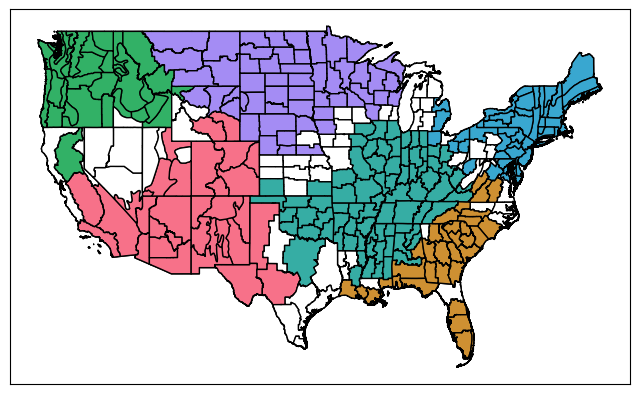

In [21]:
color_label_array = np.empty(len(gdf))
color_label_array[:] = np.nan
for i,id in enumerate(location_ids):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        l = list(dsclust_labels[i])
        if len(l) > 1:
            color_label_array[idx[0]] = -1
        else:
            color_label_array[idx[0]] = l[0]

fig,ax = plt.subplots(figsize=(8,8))
gdf['color'] = color_label_array
gdf.plot(column='color', cmap=None, ax = ax, legend=False, edgecolor = 'black', alpha = 1)
uni_labels = gdf['color'].unique()

for l in uni_labels:
    gdf_subset = gdf[gdf['color'] == l]
    gdf_subset.plot(
        column='color',
        cmap=ListedColormap([color_dict[l]]),
        ax = ax, legend=False,
        edgecolor = 'black',
        alpha = 1
    )

plt.xticks([])
plt.yticks([]) 
plt.savefig('../figures/climate/dscluster_map.png', bbox_inches = 'tight', dpi = 300)

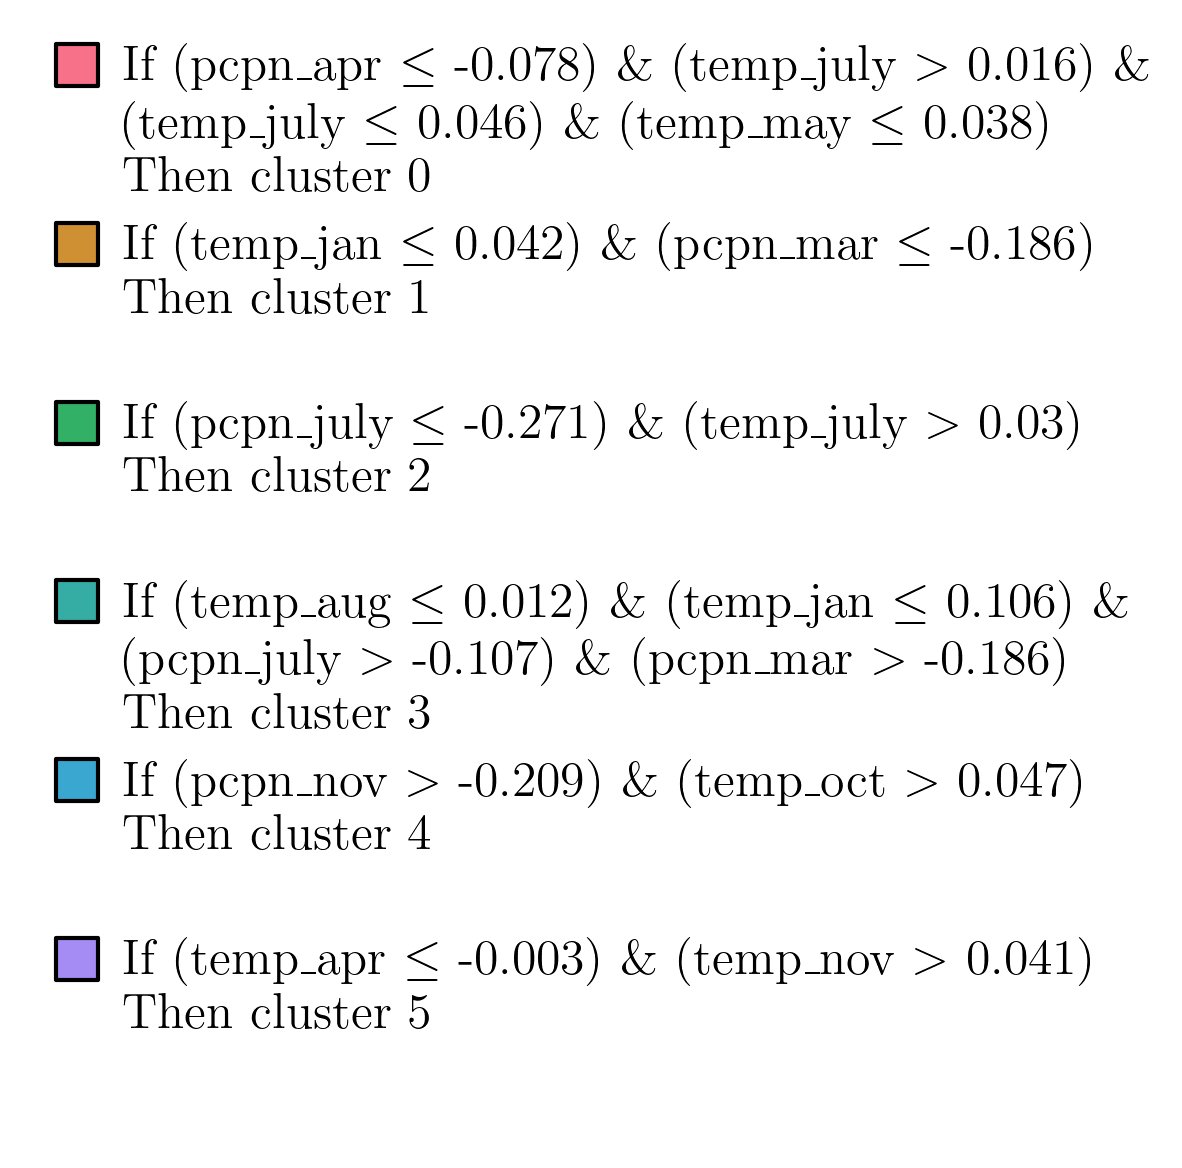

In [35]:
fname = '../figures/climate/dscluster_rules.png'
plot_decision_set(
    decision_set = dsclust.decision_set,
    rule_labels =  dsclust.decision_set_labels,
    feature_labels = feature_labels,
    data_scaler = scaler,
    color_dict = color_dict,
    size_factor = 0.8,
    filename = fname
)

In [30]:
# Module Parameters:
n,d = data.shape
k = 6
n_clusters = k
n_rules = k
frac_cover = 0.8
n_trees = 1000
data_labels = kmeans_labels
centers = kmeans.cluster_centers_

# We'll create a few variations of the forest algorithm, with different maximum depths. 
# The following begins by creating parameterized dictionaries which will be passed to 
# forest classes soon. 

# Depth 2 Forest:
forest_tree_params_depth_2 = {
    'max_depth' : 2
}

forest_params_depth_2 = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params_depth_2,
    'num_trees' : n_trees,
    'max_features' : d,
    'max_labels' : 1,
    'max_depths' : list(range(1, 2 + 1)),
    #'feature_pairings' : [list(range(12))] + [list(range(12,24))],
    'feature_pairings' : [list(range(d))],
    'train_size' : 0.75
}

# Depth 3 Forest:
forest_tree_params_depth_3 = {
    'max_depth' : 3
}

forest_params_depth_3 = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params_depth_3,
    'num_trees' : n_trees,
    'max_features' : d,
    'max_labels' : 1,
    'max_depths' : list(range(1, 3 + 1)),
    #'feature_pairings' : [list(range(12))] + [list(range(12,24))],
    'feature_pairings' : [list(range(d))],
    'train_size' : 0.75
}


# Depth 3 Forest:
forest_tree_params_depth_4 = {
    'max_depth' : 4
}

forest_params_depth_4 = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params_depth_4,
    'num_trees' : n_trees,
    'max_features' : d,
    'max_labels' : 1,
    'max_depths' : list(range(1, 4 + 1)),
    #'feature_pairings' : [list(range(12))] + [list(range(12,24))],
    'feature_pairings' : [list(range(d))],
    'train_size' : 0.75
}


# Depth IMM Forest:
forest_tree_params_depth_imm = {
    'max_depth' : imm_depth
}

forest_params_depth_imm = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params_depth_imm,
    'num_trees' : n_trees,
    'max_features' : 12,
    'max_labels' : 1,
    'max_depths' : list(range(1, imm_depth + 1)),
    'feature_pairings' : [list(range(12))] + [list(range(12,24))],
    'train_size' : 0.9
}

In [31]:
# Create and fit the decision set models
forest_depth_2 = DecisionForest(**forest_params_depth_2)
forest_depth_2.fit(data, kmeans_labels)

forest_depth_3 = DecisionForest(**forest_params_depth_2)
forest_depth_3.fit(data, kmeans_labels)

forest_depth_4 = DecisionForest(**forest_params_depth_4)
forest_depth_4.fit(data, kmeans_labels)

forest_depth_imm = DecisionForest(**forest_params_depth_imm)
forest_depth_imm.fit(data, kmeans_labels)

### Pruning

#### Tuning $\lambda$

Below we show the effect of changing the $\lambda$ parameter with in our 
submodular objective, upon both cost as well as coverage of data points.

In [32]:
model = forest_depth_2
search_range = np.linspace(0,5,101)

data_to_rules_assignment = model.get_data_to_rules_assignment(data)
prune_objective = KmeansObjective(
    X = data,
    centers = centers,
    average = True,
    normalize = True
)
selected_rules, objective_vals, coverage_vals = prune_with_grid_search(
    n_rules = n_rules,
    frac_cover = 0, # Just using 0 required coverage for now to be able to see the full picture.
    n_clusters = n_clusters,
    data_labels = data_labels,
    rule_labels = model.decision_set_labels,
    data_to_rules_assignment = data_to_rules_assignment,
    objective = prune_objective,
    lambda_search_range = search_range,
    cpu_count = 4,
    return_full = True
)

Text(0, 0.5, 'Cost')

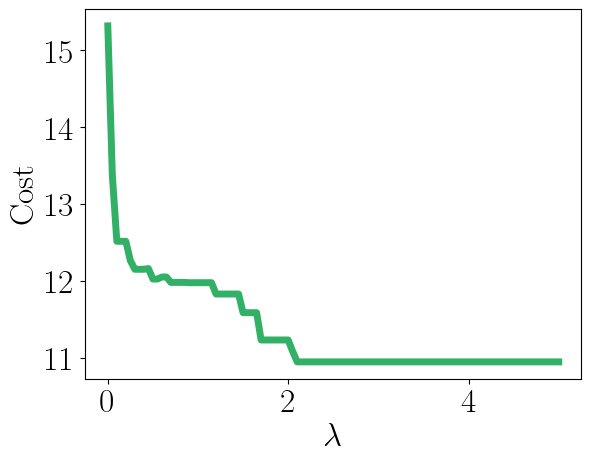

In [33]:
plt.plot(search_range, objective_vals, color = cmap(3), linewidth = 5)
plt.xlabel(r"$\lambda$")
plt.ylabel("Cost")

Text(0, 0.5, 'Coverage')

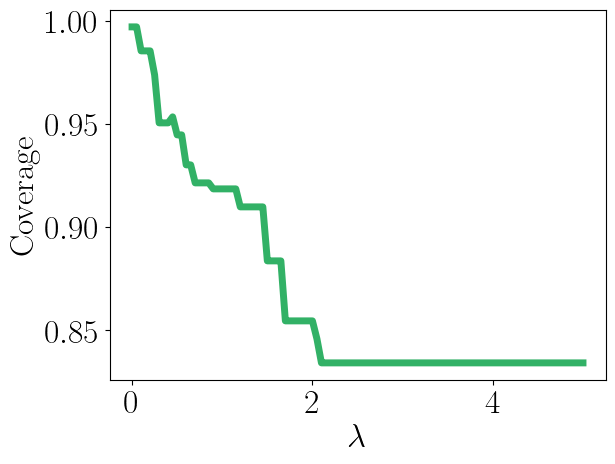

In [34]:
plt.plot(search_range, coverage_vals, color = cmap(3), linewidth = 5)
plt.xlabel(r"$\lambda$")
plt.ylabel("Coverage")

#### Selecting Rules

In [35]:
# Now we have a trained forest with a lot of rules, so we'll need to prune it 
# with a distorted greedy selection process. 

# We first give a kmeans cost objective to the grid search algorithm. This is used to 
# break ties if multiple solutions exist. 
prune_objective = KmeansObjective(
    X = data,
    centers = centers,
    average = True,
    normalize = True
)

# We then tell the forest to prune, and give 3 rules which cover 80% of the data. 
# We also specify a search range for lambda values.
prune_params = {
    'n_rules' : n_rules,
    'frac_cover' : 0.8,
    'n_clusters' : n_clusters,
    'X' : data,
    'y' : data_labels,
    'objective' : prune_objective,
    'lambda_search_range' : np.linspace(0,5,51),
    'full_search' : True,
    'cpu_count' : 1
}

In [36]:
# Now we may prune all our forests.
forest_depth_2.prune(**prune_params)
if forest_depth_2.prune_status:
    forest_depth_2_prune_predictions = forest_depth_2.pruned_predict(data, rule_labels = False)
else:
    print("Forest depth 2 pruning failed.")

forest_depth_3.prune(**prune_params)
if forest_depth_3.prune_status:
    forest_depth_3_prune_predictions = forest_depth_3.pruned_predict(data, rule_labels = False)
else:
    print("Forest depth 3 pruning failed.")

forest_depth_4.prune(**prune_params)
if forest_depth_4.prune_status:
    forest_depth_4_prune_predictions = forest_depth_4.pruned_predict(data, rule_labels = False)
else:
    print("Forest depth 4 pruning failed.")

forest_depth_imm.prune(**prune_params)
if forest_depth_imm.prune_status:
    forest_depth_imm_prune_predictions = forest_depth_imm.pruned_predict(data, rule_labels = False)
else:
    print("Forest depth IMM pruning failed.")

([], [])

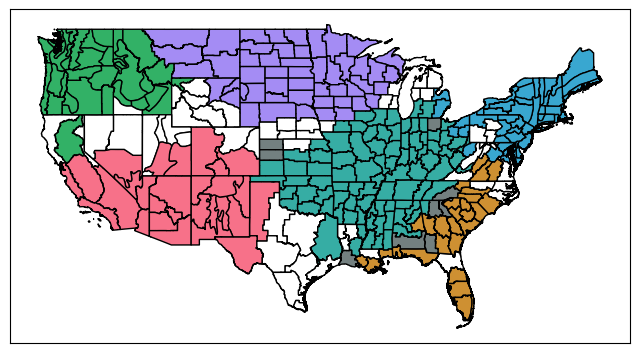

In [37]:
# Select a forest model with specific depth:
prune_predictions = forest_depth_2_prune_predictions

# And visualize its predictions:
uncover_colors = subset_colors
if len([l for l in prune_predictions if len(l) > 1]) > 0:
    uncover_colors = [overlap_color] + subset_colors
if len([l for l in prune_predictions if len(l) == 0]) > 0:
    uncover_colors = [uncovered_color] + uncover_colors

cmap_subset_uncover = ListedColormap(uncover_colors)

color_label_array = np.empty(len(gdf))
color_label_array[:] = np.nan
for i,id in enumerate(location_ids):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        l = list(prune_predictions[i])
        if len(l) == 1:
            color_label_array[idx[0]] = l[0]
        elif len(l) > 1:
            color_label_array[idx[0]] = -1
        else:
            color_label_array[idx[0]] = -2

gdf['color'] = color_label_array
fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='color', cmap=cmap_subset_uncover, ax = ax, legend=False, edgecolor = 'black', alpha = 1)
 
plt.xticks([])
plt.yticks([]) 
#plt.savefig('../figures/climate/forest_map_full_features.png', bbox_inches = 'tight', dpi = 300)

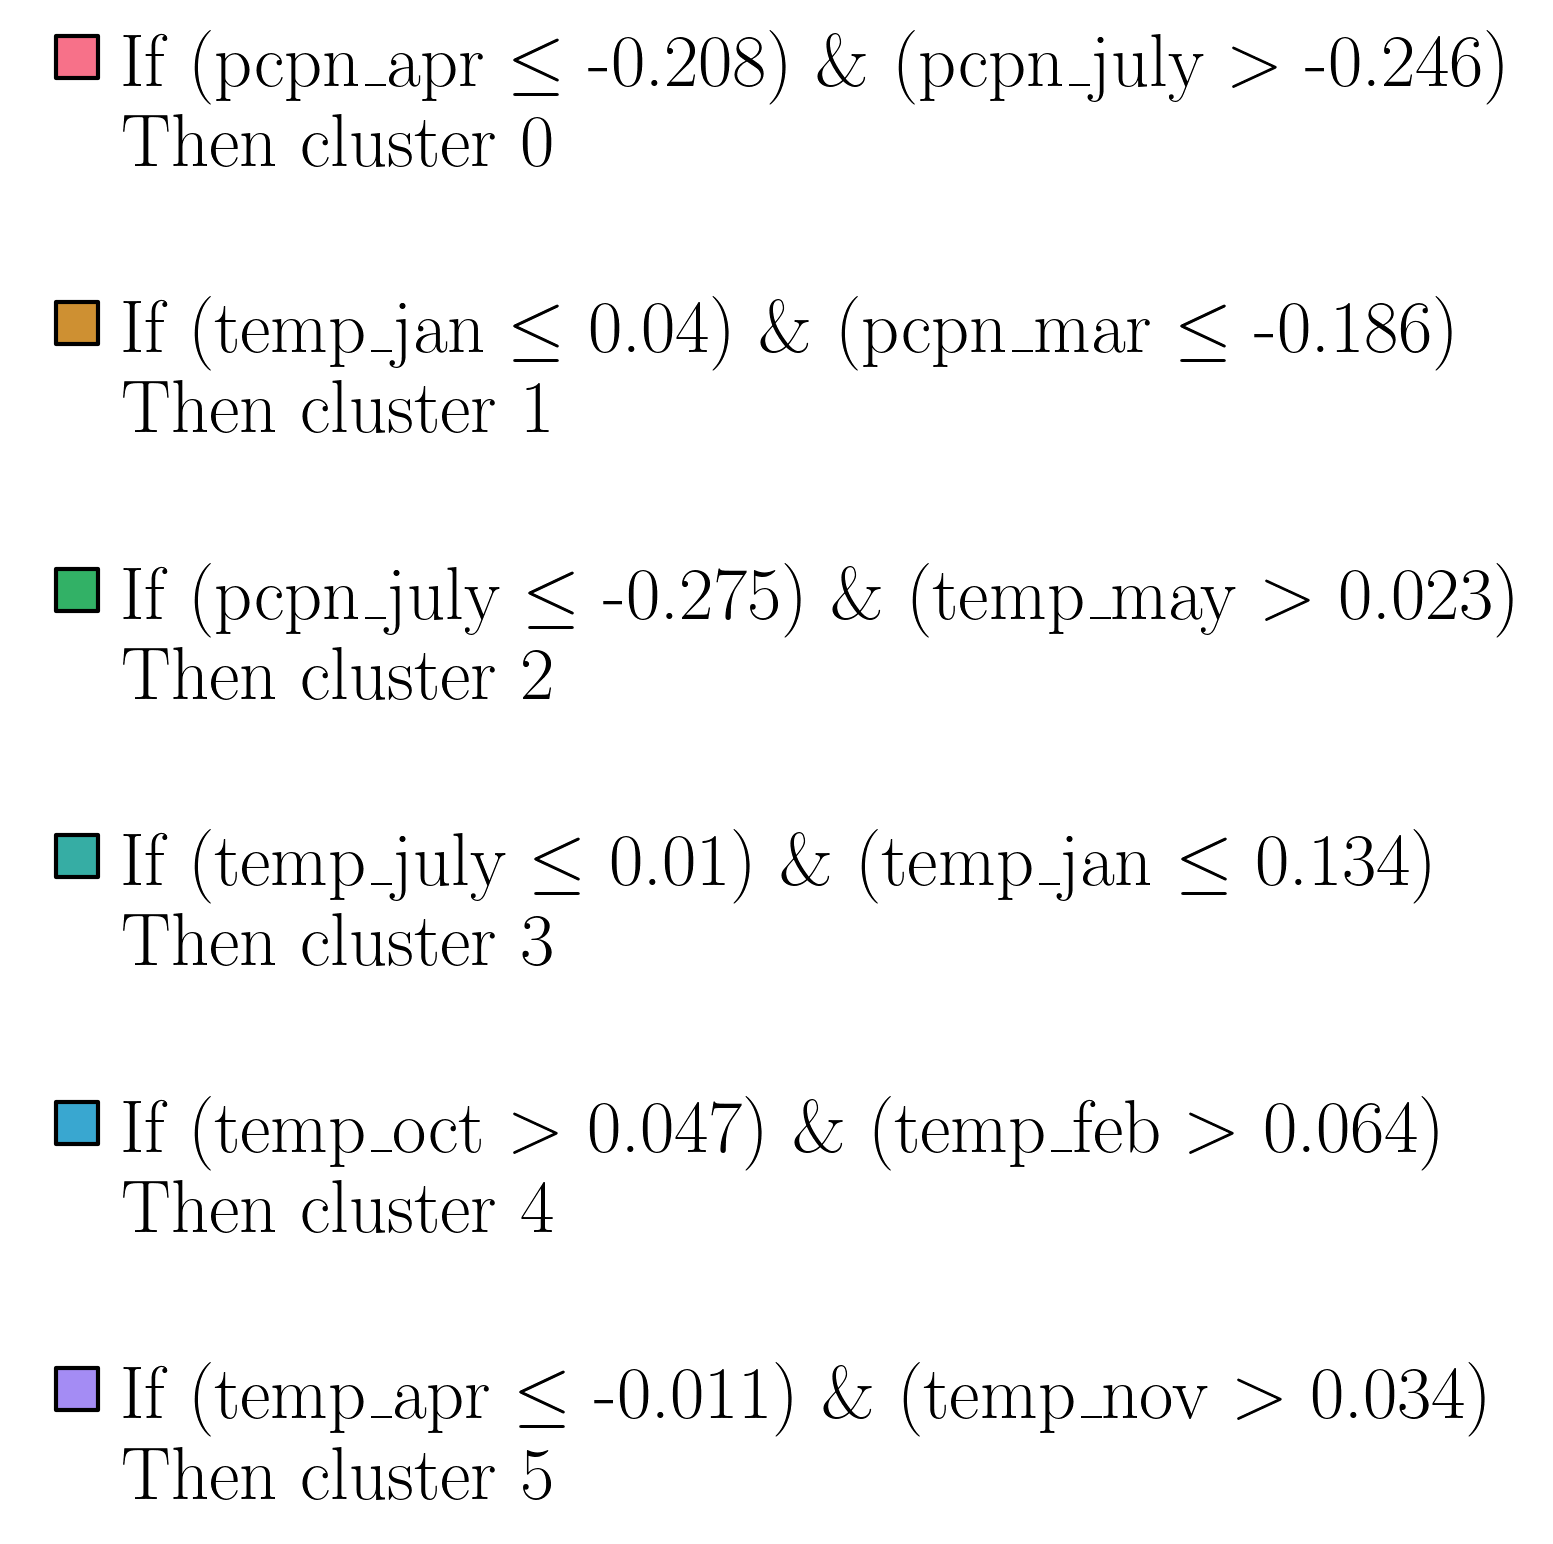

In [38]:
# Along with the corresponding decision set:

model = forest_depth_2
#fname = '../figures/climate/forest_decision_set_full_features.png'
fname = None
cluster_colors = {i: cmap_subset(i) for i in range(k)}
plot_decision_set(
    decision_set = [model.decision_set[i] for i in model.pruned_indices],
    rule_labels = [model.decision_set_labels[i] for i in model.pruned_indices],
    feature_labels = feature_labels,
    data_scaler = scaler,
    cmap = cmap_subset,
    filename = fname
)

### Distance Ratio Distributions

Since we'd like to characterize the set of uncovered and overlapped points, we visualize 
their distributions in terms of distance ratio. 

In [40]:
# Select model to compute results for:
prune_predictions = forest_depth_2_prune_predictions
assignment = labels_to_assignment(
    prune_predictions,
    n_labels = n_clusters
)

# Compute distance ratios 
distance_ratios = distance_ratio(data, centers)

# Single (unique) Covers:
single_cover_mask = np.sum(assignment, axis = 1) == 1
single_cover_size = np.sum(single_cover_mask)
single_cover_distance_ratios = distance_ratios[single_cover_mask]

# Overlaps:
overlap_mask = np.sum(assignment, axis = 1) > 1
overlap_size = np.sum(overlap_mask)
overlap_distance_ratios = distance_ratios[overlap_mask]

# Uncovereds:
uncovered_mask = np.sum(assignment, axis = 1) < 1
uncovered_size = np.sum(uncovered_mask)
uncovered_distance_ratios = distance_ratios[uncovered_mask]

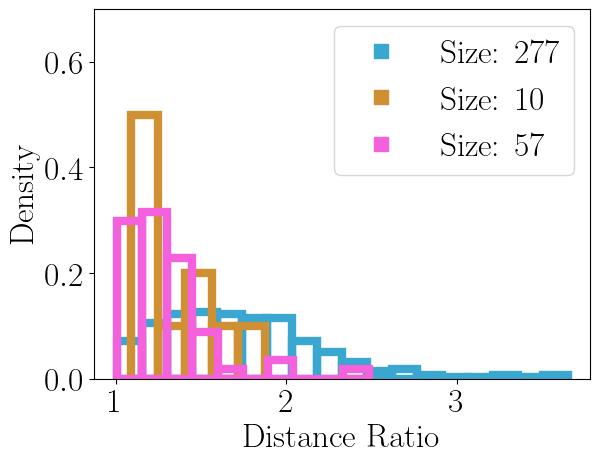

In [44]:
binwidth = 0.15
yaxis = True
cdict = {"Unique" : 5, "Overlapping" : 1, "Uncovered" : 7}
#fname = '../figures/climate/forest_depth_2_cover_dist.png'
fname = None

sns.histplot(
    single_cover_distance_ratios,
    stat = 'probability',
    binwidth = binwidth,
    alpha = 1,
    label = "Unique",
    color = cmap(cdict["Unique"]),
    fill = False,
    linewidth = 6
)
sns.histplot(
    overlap_distance_ratios,
    stat = 'probability',
    binwidth = binwidth,
    alpha = 1,
    label = "Overlap",
    color = cmap(cdict["Overlapping"]),
    fill = False,
    linewidth = 6
)
sns.histplot(
    uncovered_distance_ratios,
    stat = 'probability',
    binwidth = binwidth,
    alpha = 1,
    label = "Uncovered",
    color = cmap(cdict["Uncovered"]),
    fill = False,
    linewidth = 6,
)

if yaxis:
    plt.ylabel("Density")
else:
    plt.ylabel("")
    plt.yticks([])

legend_elements = [
    mlines.Line2D(
        [], [],
        marker = 's',
        markersize=10,
        color=cmap(cdict["Unique"]),
        lw=0,
        label= "Size: " + str(single_cover_size),
        alpha=1
    ),
    mlines.Line2D(
        [], [],
        marker = 's',
        markersize=10,
        color=cmap(cdict["Overlapping"]),
        lw=0,
        label= "Size: " + str(overlap_size),
        alpha=1
    ),
    mlines.Line2D(
        [], [],
        marker = 's',
        markersize=10,
        color=cmap(cdict["Uncovered"]),
        lw=0,
        label= "Size: " + str(uncovered_size),
        alpha=1
    ),

]

plt.xlabel("Distance Ratio")
plt.ylim(0,0.7)
plt.legend(loc = "upper right", handles=legend_elements, ncol = 1)
#plt.savefig(fname, bbox_inches = 'tight', dpi = 300)


(0.0, 1.0, 0.0, 1.0)

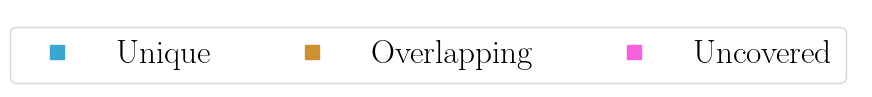

In [45]:
# Legend:
fig, ax = plt.subplots(figsize = (6,1))

cdict = {"Unique" : 5, "Overlapping" : 1, "Uncovered" : 7}

legend_elements = [
    mlines.Line2D(
        [], [],
        marker = 's',
        markersize=10,
        color=cmap(i),
        lw=0,
        label=mname,
        alpha=1
    )
    for mname,i in cdict.items()
]

ax.legend(handles=legend_elements, ncol = 3)
ax.axis('off')
#plt.savefig('../figures/climate/cover_dist_legend.png', bbox_inches = 'tight', dpi = 300)